## <center/> Digital Communication project 
<center/> Mahamat Hamid

In [23]:
from utils import *

In [24]:
# Parameters
L = 1000    # Number of bits divided by n which is number of bit/symbol associated with the modulation scheme
F = 8       # Oversampling factor
fe = 48e3   # Sampling frequency
Ω =  3      
β = 0.3     # Roll-off factor
A = 1       # Signal amplitude
Δ = 1       # Filter energy normalization factor
SNR = 15    # Signal to noise ratio


## TRANSMISSION (QPSK) ##
# Generate random bits
m = np.random.randint(0, 2, (L,2))

# Mapping bits to symbols
d = bit2Symbol_Mapping_QPSK_Gray(A, m)

# Upsampling
dech = seqSymbEch(d,F)

# Raised cosine filtering of the signal (symbol sequence)
he = filterootcos(β,F,Ω)
s_he = np.convolve(he, dech)


### Power spectral density (PSD) of the sampled signal $s_s (t)$ 

Occupied band:  7.8 kHz


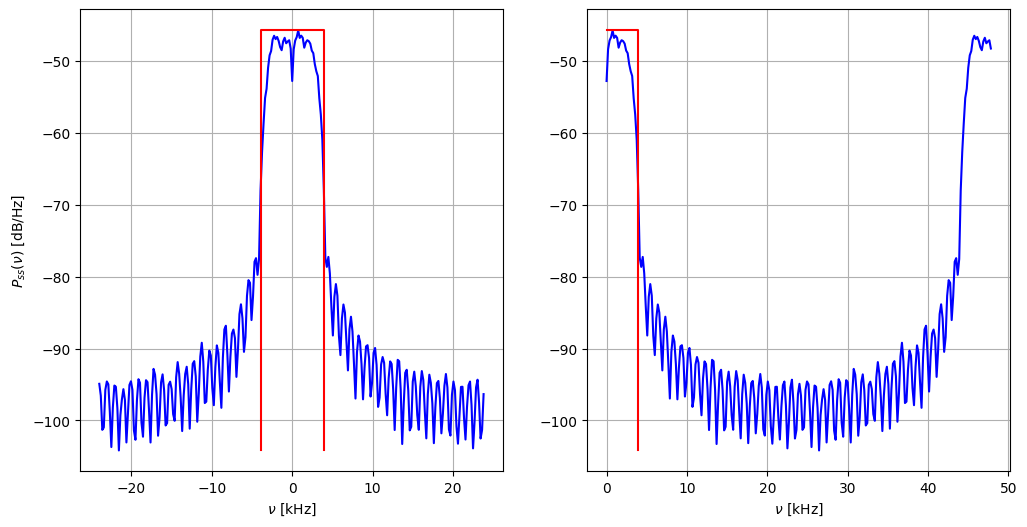

In [25]:
freq_u = 1e3 # freq unit in kHz

# Power spectral density of the emitted signal
freqs, val = sg.welch(s_he, fs=fe, return_onesided=False, scaling='density')

# Occupied band
B_occ = (1 + β) * fe/ F
print('Occupied band: ', B_occ / freq_u, 'kHz')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
idx_sort = np.argsort(freqs)
plt.plot(freqs[idx_sort] / freq_u, 10 * np.log10(val[idx_sort]), color='blue')
plt.xlabel(r'$\nu$ [kHz]')
plt.ylabel(r'$P_{ss}(\nu)$ [dB/Hz]')
max_psd = 10 * np.log10(np.max(val))
min_psd = 10 * np.log10(np.min(val))
x_f = (B_occ/2) / freq_u
plt.plot([-x_f, -x_f, x_f,x_f], [min_psd, max_psd, max_psd, min_psd], color='red', label='Occupied band')
plt.grid()

plt.subplot(1,2,2)
freqs[freqs < 0] = freqs[freqs < 0] + fe # Shift to have the negative frequencies at the end
plt.plot(freqs / freq_u, 10 * np.log10(val), color='blue')
plt.xlabel(r'$\nu$ [kHz]')
plt.plot([0, x_f,x_f], [ max_psd, max_psd, min_psd], color='red', label='Occupied band')
plt.grid()


In [4]:
## RECEPTION ##
s_hr = np.convolve(s_he, he)
s_hr = s_hr[0 : int(np.floor(len(s_hr)/(3 * F))*3*F)]

### <center/> Eye diagram at the reception

In [5]:
def eye_diagram(s_hr, eye_window, F, Ω):
    """     
    Parameters
    ----------
    s_hr : np.ndarray complex (N,1)
        output of reception filter.
    eye_window : int or float > 0
        define the window where the eye diagram will be displayed.
    F : int
        oversampling factor.
    Ω : int
        filter parameter.

    Returns
    -------
    plot the eye diagram and 
    return x,y coordinates of the eye diagram
    """


    eye_window = int(eye_window) * F
    dim2_eyeD_r = int(np.floor(len(s_hr)/(eye_window)))
    eye_diagram_r = np.empty((eye_window, dim2_eyeD_r)).astype(complex)
    for i in range(dim2_eyeD_r):
        eye_diagram_r[:,i] = s_hr[i*eye_window:(i+1)*eye_window]

    eye_diagram_r = eye_diagram_r[:,Ω-1 : -(len(he) - Ω - 1)-1]
    plt.plot(np.arange(0, eye_window), np.real(eye_diagram_r),'k')
    plt.xlim(0, eye_window-1)
    plt.grid(linestyle='--')
    plt.xlabel(r'$t/T_e$')
    return eye_window, dim2_eyeD_r



Text(0.5, 1.0, 'Eye diagram at the receiver side with \nroot raised cosine filter with roll-off factor $\\beta$ = 0.3\nand oversampling factor F = 8')

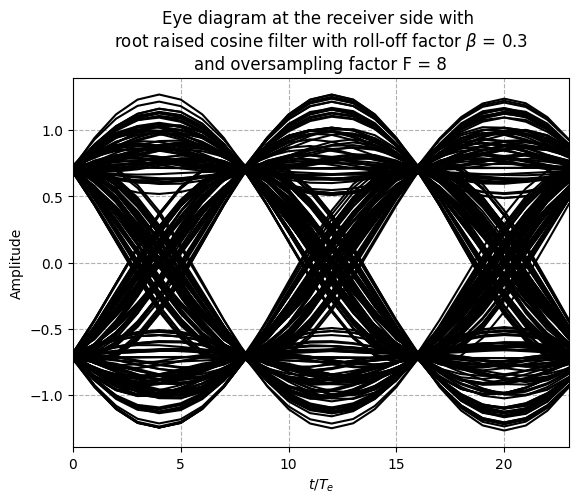

In [6]:
_ = eye_diagram(s_hr, 3, F, Ω)
plt.ylabel("Amplitude")
plt.title("Eye diagram at the receiver side with \n"+fr"root raised cosine filter with roll-off factor $\beta$ = {β}"+ "\n"+fr"and oversampling factor F = {F}")

### <center/> Synchronization

In [7]:
def sychronization(s_hr, idx_start, d, F):
    """
    Parameters
    ----------
    s_hr : np.ndarray complex (N,1)
        output of reception filter.
    idx_start : int
        index to start the clock.
    d : np.ndarray complex (L,1)
        sequence of mapped symbols.
    F : int
        oversampling factor.
    Returns
    -------
    return synchronized sampled symbols.
    """    
    s_hr_ech = s_hr[idx_start::F]
    s_hr_ech = s_hr_ech[F -2- (idx_start//F)  :  F-2 - (idx_start//F) + len(d)]
    return s_hr_ech

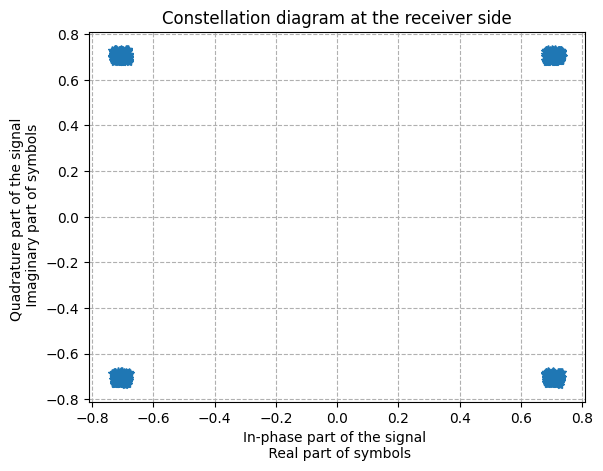

In [8]:
# selection of the samples
idx_start = 0
s_hr_ech = sychronization(s_hr, idx_start, d, F)
plt.plot(np.real(s_hr_ech), np.imag(s_hr_ech) ,'*')
plt.xlabel("In-phase part of the signal \n Real part of symbols")
plt.ylabel("Quadrature part of the signal \n Imaginary part of symbols")
plt.title("Constellation diagram at the receiver side")
plt.grid(linestyle='--')  



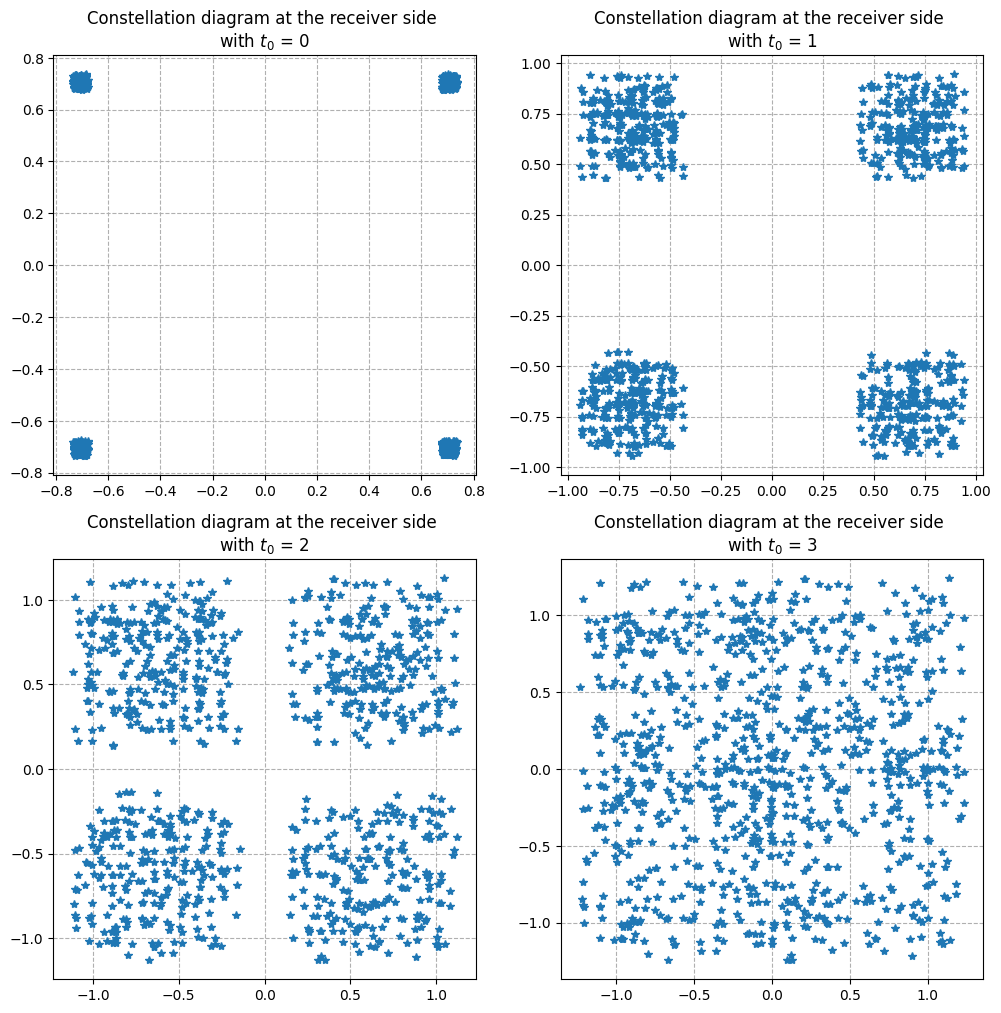

In [9]:
# subplots for 4 different idx_start
plt.figure(figsize=(12,12))
for idx_start in range(4):
    s_hr_ech = sychronization(s_hr, idx_start, d, F)
    plt.subplot(2,2,idx_start+1)
    plt.plot(np.real(s_hr_ech), np.imag(s_hr_ech) ,'*')
    #plt.xlabel("In-phase part of the signal \n Real part of symbols")
    #plt.ylabel("Quadrature part of the signal \n Imaginary part of symbols")
    plt.title("Constellation diagram at the receiver side \n" fr"with $t_0$ = "+str(idx_start))
    plt.grid(linestyle='--')



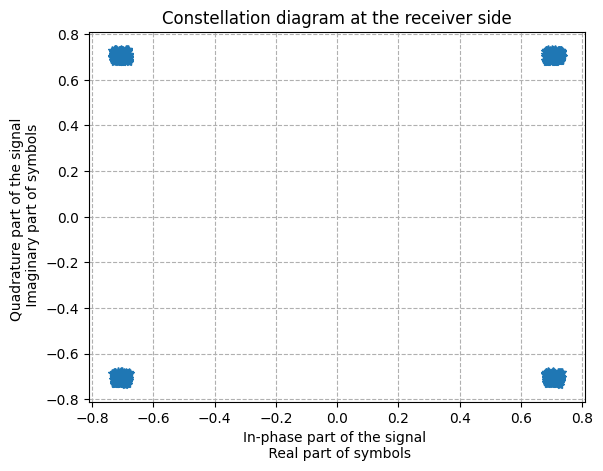

In [10]:
idx_start = 0
s_hr_ech = sychronization(s_hr, idx_start, d, F)

# Demapping symbols to bits
d_est = MLSymbolDetectorQPSKlowCPLX(A,Δ,s_hr_ech)
plt.plot(np.real(s_hr_ech), np.imag(s_hr_ech) ,'*')
plt.xlabel("In-phase part of the signal \n Real part of symbols")
plt.ylabel("Quadrature part of the signal \n Imaginary part of symbols")
plt.title("Constellation diagram at the receiver side")
plt.grid(linestyle='--')  

In [11]:
m_demapped = symbol2Bit_Demapping_QPSK_Gray(d_est)

In [12]:
(m_demapped == m).all()

np.True_

### <center/> Noisy AWGN channel

Text(0, 0.5, 'Quadrature part of the signal \n Imaginary part of symbols')

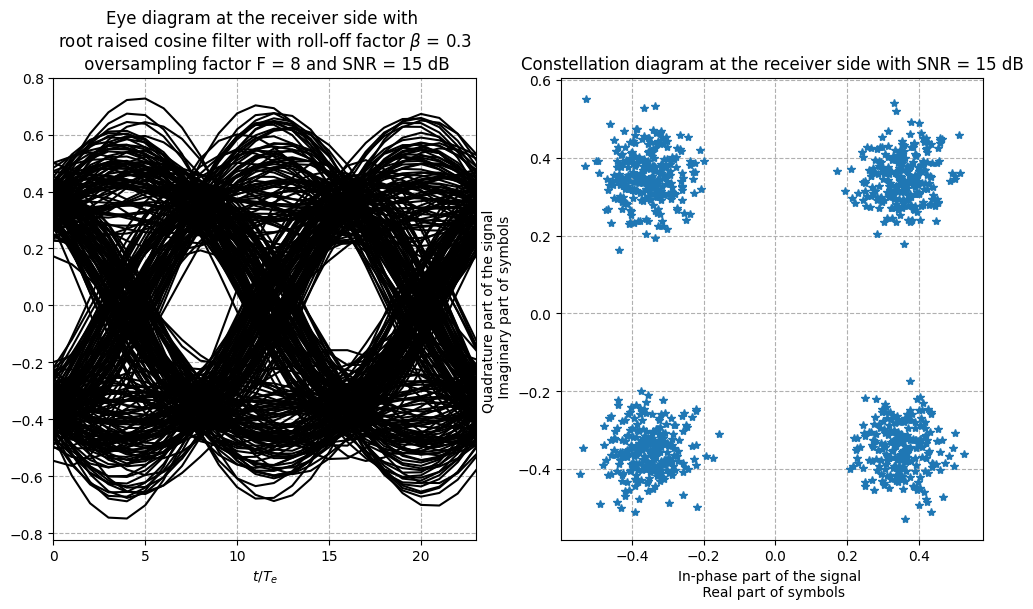

In [13]:
var = (A*Δ/2)**2 * 10 ** (-SNR/10)
z = AWGN(Δ, var, s_he)
s_hr = np.convolve(z, he)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
_ = eye_diagram(s_hr, 3, F, Ω)
plt.title("Eye diagram at the receiver side with \n"+fr"root raised cosine filter with roll-off factor $\beta$ = {β}"+ "\n"+fr" oversampling factor F = {F} and SNR = {SNR} dB")

plt.subplot(1,2,2)
idx_start = 0
s_hr_ech = sychronization(s_hr, idx_start, d, F)
plt.plot(np.real(s_hr_ech), np.imag(s_hr_ech) ,'*')
plt.title("Constellation diagram at the receiver side with SNR = "+str(SNR)+" dB")
plt.grid(linestyle='--')
plt.xlabel("In-phase part of the signal \n Real part of symbols")
plt.ylabel("Quadrature part of the signal \n Imaginary part of symbols")

### <center/> SNR vs BER simulation curve

In [14]:
nb_frames = 100

# Parameters
L = 2000    # Number of bits divided by n which is number of bit/symbol associated with the modulation scheme
F = 8       # Oversampling factor
fe = 48e3   # Sampling frequency
Ω =  3      
β = 0.3     # Roll-off factor
A = 1       # Signal amplitude
Δ = 1       # Filter energy normalization factor
SNR = 15    # Signal to noise ratio

he = filterootcos(β,F,Ω)

SNR_list = np.arange(-2, 13)
SER = []
BER = []
idx_start = 0


for snr in SNR_list :
    ser_snr = []
    ber_snr = []

    for k in range(nb_frames) :
        
        m = np.random.randint(0, 2, (L,2))
        d = bit2Symbol_Mapping_QPSK_Gray(A, m)
        dech = seqSymbEch(d,F)
        s_he = np.convolve(he, dech)

        var = (A*Δ/2)**2 * 10 ** (-snr/10)
        z = AWGN(Δ, var, s_he)
        s_hr = np.convolve(z, he)

        s_hr_ech = sychronization(s_hr, idx_start, d, F)
        d_est = MLSymbolDetectorQPSKlowCPLX(A,Δ,s_hr_ech)
        m_demapped = symbol2Bit_Demapping_QPSK_Gray(d_est)

        ser_snr.append(np.sum(np.abs(d_est - d) != 0)/L)
        ber_snr.append(np.sum(np.abs(m_demapped - m) != 0)/(2*L))
    
    SER.append(np.mean(ser_snr))
    BER.append(np.mean(ber_snr))


In [15]:
from scipy.special import erfc

In [16]:
# theoretical SER and BER
SER_th = erfc((0.5*10**(SNR_list/10))**0.5)
BER_th = SER_th / 2

### <center/> Error probability
$$P_\text{es}^\text{M-PSK} = \text{erfc}\left(\left(\sin\dfrac{\pi}{M}\right)^2\dfrac{\bar{E}}{N_0}\right) $$

$$P_\text{eb}^\text{M-PSK} = \frac{1}{\log_2(M)}\text{erfc}\left(\left(\sin\dfrac{\pi}{M}\right)^2\dfrac{\bar{E}}{N_0}\right) $$

Text(0.5, 1.0, 'SER and BER as a function of SNR')

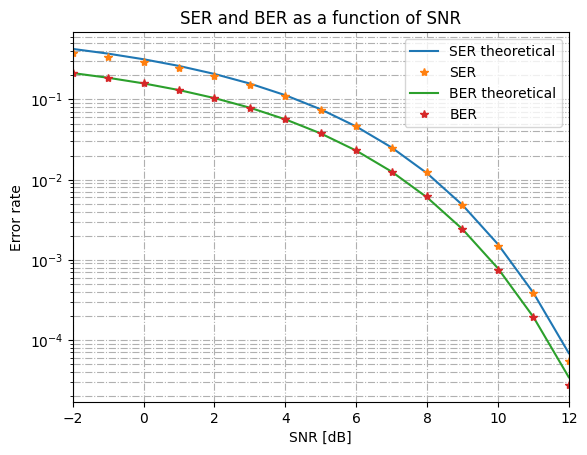

In [17]:
plt.semilogy(SNR_list, SER_th, label='SER theoretical')
plt.semilogy(SNR_list, SER, '*', label='SER')
plt.semilogy(SNR_list, BER_th, label='BER theoretical')
plt.semilogy(SNR_list, BER, '*', label='BER')
plt.xlabel('SNR [dB]')
plt.ylabel('Error rate')   
plt.grid(linestyle='-.', which='both')
plt.xlim(-2, 12)
plt.legend()
plt.title('SER and BER as a function of SNR')

In [18]:
## Emission ##
seed=17021999
np.random.seed(seed)
Lp = 256
m_preamble = np.random.randint(0, 2, (Lp,2))
L = 10_000
m_payload = np.random.randint(0, 2, (L,2))
m = np.vstack((m_preamble, m_payload))
d = bit2Symbol_Mapping_QPSK_Gray(A, m)
dech = seqSymbEch(d,F)

## Channel ##
channel_delay = 100
dech_delayed = np.concatenate((np.zeros(channel_delay), dech))
s_he = np.convolve(he, dech)
z = AWGN(Δ, var, s_he)

## Reception ##
s_hr = np.convolve(z, he)

In [19]:
np.random.seed(seed)
corr = np.correlate(s_he, seqSymbEch(bit2Symbol_Mapping_QPSK_Gray(A,np.random.randint(0, 2, (Lp,2))), F))

In [20]:
tau_est = np.argmax(np.abs(corr))

In [21]:
tau_est

np.int64(24)

In [22]:
s_hr_ech = sychronization(s_hr, tau_est, d, F)